## Fitting Limit Cycles



In [1]:
import numpy as np
import functorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_vector_field import utilities, plotting, vector_field

We generate paired observations of $(x, \dot x)$ for a few different dynamical systems. See ```generate_data.py``` for details.

In [2]:
xs = np.load('data/simple_rot_field_x.npy')
dot_xs = np.load('data/simple_rot_field_dx.npy')

full_ds = torch.utils.data.TensorDataset(
    torch.from_numpy(xs.astype(np.float32)), 
    torch.from_numpy(dot_xs.astype(np.float32))
)
train_len = int(xs.shape[0] * 0.8)
test_len = xs.shape[0] - train_len

train_ds, test_ds = torch.utils.data.random_split(full_ds, [train_len, test_len])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size= 128, shuffle=True)

Let's visualize the dynamical system. 

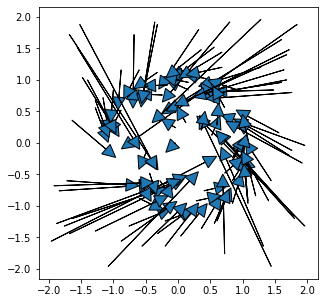

In [3]:
idx = np.random.choice(np.arange(xs.shape[0]), size=100)
plotting.plot_dyn_sys_data(xs[idx], dot_xs[idx])

### Defining the Potential Field

Now we need to define the parametrization of the vector field. 

To start with, this is just a slightly relaxed version of the original formulation. Concretely, we introduce $\theta$-dependent nonnegative coefficients into the equation $h_\theta = a_\theta r^2 + b_\theta \exp(-r^2)$. $a_\theta, b_\theta$ are parametrized by neural nets. 


In [4]:
def radial_coordinate_transform(x):
    """
    x is a tensor of shape [...,2] describing 2D coordinates
    Return a tensor of shape [...,1] (radius) and [...,2] (unit vector)
    """
    r = torch.linalg.norm(x, dim=-1, keepdim=True)
    x_unit = x / r
    return r, x_unit

class SimplePotentialField(nn.Module):
    def __init__(self):
        super(SimplePotentialField, self).__init__()
        self.a = nn.Sequential(
            nn.Linear(2, 8),
            nn.ELU(),
            nn.Linear(8,1)
        )
        self.b = nn.Sequential(
            nn.Linear(2, 8),
            nn.ELU(),
            nn.Linear(8,1)
        )

    def forward(self, x):
        r, x_unit = radial_coordinate_transform(x)
        # Ensure r**2 coeff is nonnegative
        rsq_coeff = F.elu(self.a(x_unit)) + 1
        # Ensure exp coeff is positive
        rexp_coeff = F.elu(self.b(x_unit)) + 2
        return rsq_coeff * r ** 2 \
            + rexp_coeff * torch.exp(-r**2)


Let's visualize the unoptimized potential field. 

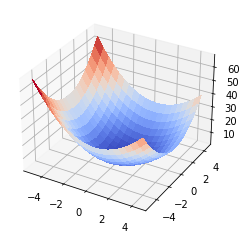

In [5]:
potential_field = SimplePotentialField()
p_field_wrapped = vector_field.TorchToNumpyPotentialFieldWrapper(potential_field)
plotting.plot_potential_field(p_field_wrapped, np.array([-5, 5]), np.array([-5, 5]), step_size = 0.5, max_clip = 1000, min_clip=-1000)

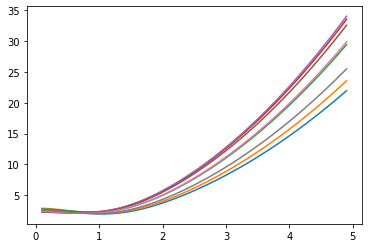

In [6]:
plotting.plot_sections(
    p_field_wrapped, 
    rs = np.arange(0, 5, step=0.1), 
    thetas=np.arange(8) * np.pi / 4
)

Not bad. Even without optimization, the potential field already has the desired 'bowl' shape along rays from 0 while still being smooth over the full state space (by construction). 

### Defining the Rotational Field


In [7]:
class SimpleRotationalField(nn.Module):
    def __init__(self):
        super(SimpleRotationalField, self).__init__()
        self.r = nn.Sequential(
            nn.Linear(2, 8),
            nn.ELU(),
            nn.Linear(8,1)
        )

    def forward(self, x):
        # Make magnitude nonnegative
        magnitude = F.elu(self.r(x)) + 1
        _, x_unit = radial_coordinate_transform(x)
        
        x1_unit, x2_unit = x_unit[...,0].unsqueeze(-1), x_unit[...,1].unsqueeze(-1)
        v_unit = torch.cat([-x2_unit, x1_unit], dim=-1)
        return magnitude * v_unit

Again, let's see what the unoptimized version looks like. 

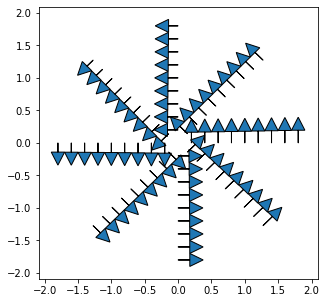

In [8]:
rotational_field = SimpleRotationalField()
r_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(rotational_field)

def get_circle_points(rs: np.ndarray, thetas: np.ndarray):
    points = []
    for r in rs:
        for theta in thetas:
            points.append(np.array([r * np.cos(theta), r * np.sin(theta)]))
    return points

circle_points = get_circle_points(
    rs = np.arange(0,2,0.2),
    thetas = np.arange(8) * np.pi / 4
)

plotting.plot_vectors(
    r_field_wrapped, circle_points
)

So far so good.

### Combining the Two Fields

We define a utility class for getting the gradient of an NN instead of the value.

Note this will only work for scalar-valued NNs. 

In [9]:
class GradientWrapper(nn.Module):
    """ Wraps a scalar-valued nn.Module to get the gradient instead of the value """
    def __init__(self, net: nn.Module, positive: bool = True):
        super(GradientWrapper, self).__init__()
        self.net = net
        self.sign = 1 if positive else -1
        net_fn, net_params, net_buffer = functorch.make_functional_with_buffers(net)

        def net_forward_fn(x):
            """ x is assumed not to have the batch dimension """ 
            out = net_fn(net_params, net_buffer, x)
            out = out.squeeze()
            return out

        self.grad_net_fn = functorch.grad(net_forward_fn)
        # vmap lets us spread the application of grad_fn to each sample in the batch
        self.batched_grad_net_fn = functorch.vmap(functorch.grad(net_forward_fn))

    def forward(self, x):
        if len(x.shape) == 1:
            print("Batch dimension not found; applying unbatched gradient")
            return self.grad_net_fn(x) * self.sign
        elif len(x.shape) >= 2:
            return self.batched_grad_net_fn(x) * self.sign
        else:
            raise Exception(f"Invalid tensor of shape {x.shape} passed")


class LinearCombinationWrapper(nn.Module):
    """Linearly combine two nn Modules"""
    def __init__(self, v1, v2, a1 = 0.5, a2 = 0.5):
        super(LinearCombinationWrapper, self).__init__()
        self.v1 = v1
        self.v2 = v2 
        self.a1 = a1
        self.a2 = a2 

    def forward(self, x):
        return self.a1 * self.v1(x) + self.a2 * self.v2(x)

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

/Users/fernandoaceromarchesotti1/miniconda3/envs/limcyc/lib/python3.8/site-packages/matplotlib/patches.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  cx = self._dx / distance
/Users/fernandoaceromarchesotti1/miniconda3/envs/limcyc/lib/python3.8/site-packages/matplotlib/patches.py:1445: RuntimeWarning: invalid value encountered in double_scalars
  sx = self._dy / distance


Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

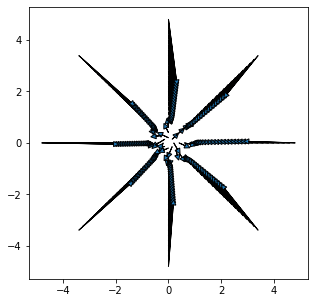

In [10]:
g = GradientWrapper(potential_field, positive=False)
g_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(g)

circle_points = get_circle_points(
    rs = np.arange(0,5,0.2),
    thetas = np.arange(8) * np.pi / 4
)

plotting.plot_vectors(g_field_wrapped, circle_points)

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

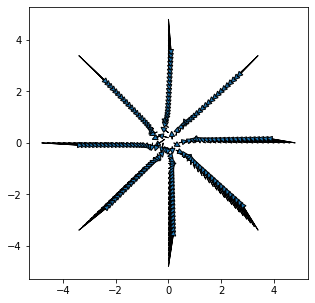

In [11]:
combined_field = LinearCombinationWrapper(
    GradientWrapper(potential_field, positive=False),
    rotational_field
)
c_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(combined_field)

plotting.plot_vectors(
    c_field_wrapped, circle_points
)

We define some utilities for training and testing the model on the systems ID task

In [12]:
def train(
    net: nn.Module, 
    train_loader: torch.utils.data.DataLoader,  
    learning_rate = 1e-3,  
    momentum=0.9,
    n_epochs = 10,
):
    criterion = nn.HuberLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimizes
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return net

def eval(net, test_ds):
    with torch.no_grad():
        features, targets = test_ds[:]
        preds_np = net(features).detach().cpu().numpy()
        targets_np = targets.detach().cpu().numpy()
        return preds_np, targets_np

In [13]:
def build_baseline_net():
    return nn.Sequential(
        nn.Linear(2, 8),
        nn.ELU(),
        nn.Linear(8, 2)
    )

In [14]:
baseline_net = train(build_baseline_net(), train_loader, n_epochs=200)

[1,    10] loss: 2.359
[1,    20] loss: 2.345
[1,    30] loss: 2.370
[1,    40] loss: 2.193
[1,    50] loss: 2.238
[1,    60] loss: 2.208
[2,    10] loss: 2.054
[2,    20] loss: 2.250
[2,    30] loss: 2.089
[2,    40] loss: 2.125
[2,    50] loss: 1.985
[2,    60] loss: 1.858
[3,    10] loss: 1.978
[3,    20] loss: 1.881
[3,    30] loss: 1.853
[3,    40] loss: 1.802
[3,    50] loss: 1.849
[3,    60] loss: 1.868
[4,    10] loss: 1.766
[4,    20] loss: 1.743
[4,    30] loss: 1.707
[4,    40] loss: 1.572
[4,    50] loss: 1.649
[4,    60] loss: 1.616
[5,    10] loss: 1.447
[5,    20] loss: 1.513
[5,    30] loss: 1.564
[5,    40] loss: 1.445
[5,    50] loss: 1.396
[5,    60] loss: 1.493
[6,    10] loss: 1.320
[6,    20] loss: 1.364
[6,    30] loss: 1.352
[6,    40] loss: 1.371
[6,    50] loss: 1.221
[6,    60] loss: 1.254
[7,    10] loss: 1.221
[7,    20] loss: 1.239
[7,    30] loss: 1.167
[7,    40] loss: 1.214
[7,    50] loss: 1.150
[7,    60] loss: 1.146
[8,    10] loss: 1.107
[8,    20] 

[60,    20] loss: 0.998
[60,    30] loss: 0.982
[60,    40] loss: 1.005
[60,    50] loss: 0.982
[60,    60] loss: 0.999
[61,    10] loss: 0.981
[61,    20] loss: 0.976
[61,    30] loss: 1.009
[61,    40] loss: 0.986
[61,    50] loss: 0.977
[61,    60] loss: 1.022
[62,    10] loss: 0.908
[62,    20] loss: 0.981
[62,    30] loss: 0.977
[62,    40] loss: 0.997
[62,    50] loss: 1.017
[62,    60] loss: 1.063
[63,    10] loss: 0.990
[63,    20] loss: 1.006
[63,    30] loss: 0.963
[63,    40] loss: 0.971
[63,    50] loss: 0.995
[63,    60] loss: 0.989
[64,    10] loss: 1.003
[64,    20] loss: 0.976
[64,    30] loss: 1.009
[64,    40] loss: 0.995
[64,    50] loss: 0.958
[64,    60] loss: 1.010
[65,    10] loss: 0.954
[65,    20] loss: 0.989
[65,    30] loss: 0.953
[65,    40] loss: 1.004
[65,    50] loss: 1.020
[65,    60] loss: 1.016
[66,    10] loss: 1.037
[66,    20] loss: 0.993
[66,    30] loss: 0.999
[66,    40] loss: 0.957
[66,    50] loss: 0.992
[66,    60] loss: 0.959
[67,    10] loss

[118,    30] loss: 0.888
[118,    40] loss: 0.912
[118,    50] loss: 0.883
[118,    60] loss: 0.926
[119,    10] loss: 0.919
[119,    20] loss: 0.888
[119,    30] loss: 0.854
[119,    40] loss: 0.910
[119,    50] loss: 0.834
[119,    60] loss: 0.920
[120,    10] loss: 0.903
[120,    20] loss: 0.907
[120,    30] loss: 0.848
[120,    40] loss: 0.854
[120,    50] loss: 0.886
[120,    60] loss: 0.907
[121,    10] loss: 0.853
[121,    20] loss: 0.912
[121,    30] loss: 0.923
[121,    40] loss: 0.870
[121,    50] loss: 0.908
[121,    60] loss: 0.850
[122,    10] loss: 0.872
[122,    20] loss: 0.874
[122,    30] loss: 0.832
[122,    40] loss: 0.940
[122,    50] loss: 0.891
[122,    60] loss: 0.883
[123,    10] loss: 0.870
[123,    20] loss: 0.878
[123,    30] loss: 0.860
[123,    40] loss: 0.886
[123,    50] loss: 0.881
[123,    60] loss: 0.876
[124,    10] loss: 0.921
[124,    20] loss: 0.887
[124,    30] loss: 0.878
[124,    40] loss: 0.855
[124,    50] loss: 0.903
[124,    60] loss: 0.815


[174,    20] loss: 0.710
[174,    30] loss: 0.715
[174,    40] loss: 0.653
[174,    50] loss: 0.676
[174,    60] loss: 0.639
[175,    10] loss: 0.686
[175,    20] loss: 0.667
[175,    30] loss: 0.677
[175,    40] loss: 0.697
[175,    50] loss: 0.707
[175,    60] loss: 0.646
[176,    10] loss: 0.637
[176,    20] loss: 0.676
[176,    30] loss: 0.693
[176,    40] loss: 0.641
[176,    50] loss: 0.718
[176,    60] loss: 0.690
[177,    10] loss: 0.684
[177,    20] loss: 0.670
[177,    30] loss: 0.653
[177,    40] loss: 0.649
[177,    50] loss: 0.638
[177,    60] loss: 0.732
[178,    10] loss: 0.622
[178,    20] loss: 0.695
[178,    30] loss: 0.636
[178,    40] loss: 0.660
[178,    50] loss: 0.683
[178,    60] loss: 0.680
[179,    10] loss: 0.689
[179,    20] loss: 0.675
[179,    30] loss: 0.684
[179,    40] loss: 0.667
[179,    50] loss: 0.632
[179,    60] loss: 0.636
[180,    10] loss: 0.620
[180,    20] loss: 0.687
[180,    30] loss: 0.656
[180,    40] loss: 0.662
[180,    50] loss: 0.657


In [15]:
net = train(combined_field, train_loader, n_epochs = 200, learning_rate=1e-4)

[1,    10] loss: 1.343
[1,    20] loss: 1.415
[1,    30] loss: 1.351
[1,    40] loss: 1.346
[1,    50] loss: 1.309
[1,    60] loss: 1208873780.343
[2,    10] loss: 1.344
[2,    20] loss: 1.339
[2,    30] loss: 1.320
[2,    40] loss: 1.368
[2,    50] loss: 1208873780.380
[2,    60] loss: 1.347
[3,    10] loss: 1208873780.446
[3,    20] loss: 1.318
[3,    30] loss: 1.324
[3,    40] loss: 1.297
[3,    50] loss: 1.321
[3,    60] loss: 1.367
[4,    10] loss: 1.243
[4,    20] loss: 1.364
[4,    30] loss: 1.359
[4,    40] loss: 1.301
[4,    50] loss: 1208873780.422
[4,    60] loss: 1.379
[5,    10] loss: 1.356
[5,    20] loss: 1.340
[5,    30] loss: 1.408
[5,    40] loss: 1.321
[5,    50] loss: 1.284
[5,    60] loss: 1208873780.372
[6,    10] loss: 1.250
[6,    20] loss: 1.400
[6,    30] loss: 1.344
[6,    40] loss: 1.311
[6,    50] loss: 1208873780.430
[6,    60] loss: 1.352
[7,    10] loss: 1.338
[7,    20] loss: 1.353
[7,    30] loss: 1.373
[7,    40] loss: 1208873780.363
[7,    50] loss: 

[55,    20] loss: 1.271
[55,    30] loss: 1.155
[55,    40] loss: 1.199
[55,    50] loss: 1208873780.318
[55,    60] loss: 1.387
[56,    10] loss: 1.305
[56,    20] loss: 1.316
[56,    30] loss: 1.400
[56,    40] loss: 1.246
[56,    50] loss: 1.238
[56,    60] loss: 1208873780.244
[57,    10] loss: 1.259
[57,    20] loss: 1.225
[57,    30] loss: 1.342
[57,    40] loss: 1208873780.414
[57,    50] loss: 1.238
[57,    60] loss: 1.240
[58,    10] loss: 1.273
[58,    20] loss: 1208873780.305
[58,    30] loss: 1.239
[58,    40] loss: 1.306
[58,    50] loss: 1.245
[58,    60] loss: 1.312
[59,    10] loss: 1.214
[59,    20] loss: 1.290
[59,    30] loss: 1.363
[59,    40] loss: 1.275
[59,    50] loss: 1.241
[59,    60] loss: 1208873780.334
[60,    10] loss: 1.214
[60,    20] loss: 1.294
[60,    30] loss: 1.333
[60,    40] loss: 1208873780.458
[60,    50] loss: 1.169
[60,    60] loss: 1.215
[61,    10] loss: 1.328
[61,    20] loss: 1.281
[61,    30] loss: 1.335
[61,    40] loss: 1.226
[61,    50

[108,    60] loss: 1.253
[109,    10] loss: 1208873780.216
[109,    20] loss: 1.317
[109,    30] loss: 1.219
[109,    40] loss: 1.251
[109,    50] loss: 1.205
[109,    60] loss: 1.264
[110,    10] loss: 1.238
[110,    20] loss: 1.243
[110,    30] loss: 1208873780.249
[110,    40] loss: 1.221
[110,    50] loss: 1.254
[110,    60] loss: 1.328
[111,    10] loss: 1.136
[111,    20] loss: 1208873780.318
[111,    30] loss: 1.281
[111,    40] loss: 1.307
[111,    50] loss: 1.216
[111,    60] loss: 1.278
[112,    10] loss: 1.218
[112,    20] loss: 1.263
[112,    30] loss: 1208873780.297
[112,    40] loss: 1.308
[112,    50] loss: 1.224
[112,    60] loss: 1.246
[113,    10] loss: 1.340
[113,    20] loss: 1.156
[113,    30] loss: 1.230
[113,    40] loss: 1208873780.356
[113,    50] loss: 1.211
[113,    60] loss: 1.215
[114,    10] loss: 1.194
[114,    20] loss: 1.201
[114,    30] loss: 1.301
[114,    40] loss: 1.301
[114,    50] loss: 1208873780.243
[114,    60] loss: 1.226
[115,    10] loss: 12

[160,    40] loss: 1.260
[160,    50] loss: 1.185
[160,    60] loss: 1.233
[161,    10] loss: 1.225
[161,    20] loss: 1.166
[161,    30] loss: 1.324
[161,    40] loss: 1208873780.340
[161,    50] loss: 1.213
[161,    60] loss: 1.229
[162,    10] loss: 1.161
[162,    20] loss: 1.213
[162,    30] loss: 1.312
[162,    40] loss: 1.199
[162,    50] loss: 1.258
[162,    60] loss: 1208873780.328
[163,    10] loss: 1208873780.325
[163,    20] loss: 1.209
[163,    30] loss: 1.320
[163,    40] loss: 1.202
[163,    50] loss: 1.167
[163,    60] loss: 1.234
[164,    10] loss: 1208873780.309
[164,    20] loss: 1.166
[164,    30] loss: 1.232
[164,    40] loss: 1.260
[164,    50] loss: 1.292
[164,    60] loss: 1.163
[165,    10] loss: 1.217
[165,    20] loss: 1.280
[165,    30] loss: 1.255
[165,    40] loss: 1.243
[165,    50] loss: 1.209
[165,    60] loss: 1.194
[166,    10] loss: 1.213
[166,    20] loss: 1.268
[166,    30] loss: 1.205
[166,    40] loss: 1208873780.386
[166,    50] loss: 1.192
[166,

In [16]:
preds, targets = eval(net, test_ds)

In [17]:
learned_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(net)
baseline_field_wrapped = vector_field.TorchToNumpyVectorFieldWrapper(baseline_net)

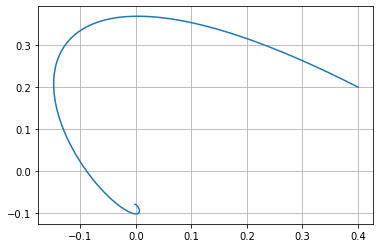

In [18]:
history = utilities.simulate_trajectory(
    baseline_field_wrapped, 
    np.array([0.4, 0.2]), 
    num_iters=1000,
    grad_clip=0.1,
    ascending=True
)
plotting.plot_histories([history])

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

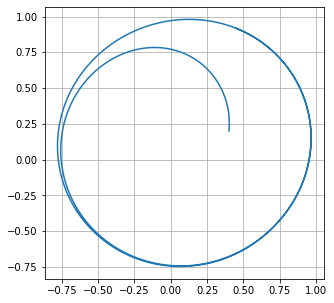

In [19]:
history = utilities.simulate_trajectory(
    learned_field_wrapped, 
    np.array([0.4, 0.2]), 
    num_iters=1000,
    ascending=True,
    grad_clip=0.1
)
plotting.plot_histories([history], figsize=(5,5))

Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dimension not found; applying unbatched gradient
Batch dime

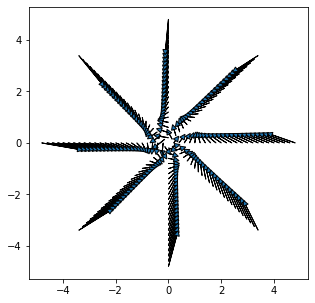

In [20]:
plotting.plot_vectors(
    learned_field_wrapped, circle_points
)